# Create a LangGraph Tool with Anypoint API

Referrenc to [Subclass BaseTool](https://python.langchain.com/v0.2/docs/how_to/custom_tools/#subclass-basetool). You can define a custom tool by sub-classing from BaseTool. This provides maximal control over the tool definition, but requires writing more code.

The Anypoint API [Create an AI Agent with Llama](https://medium.com/@yuxiaojian/create-an-ai-agent-with-llama-guard-in-anypoint-platform-a313b2c0b51f)

In [1]:
#%%capture --no-stderr
#%pip install -U langchain-core langchain langchain_openai langgraph

In [2]:
from typing import Optional, Type, Dict
from langchain.pydantic_v1 import BaseModel, Field
from langchain_core.callbacks import (
    AsyncCallbackManagerForToolRun,
    CallbackManagerForToolRun,
)
from langchain_core.tools import BaseTool
from langchain_core.tools import ToolException
import httpx

## Create the Tool

In [3]:
# Define the input param schema
class LlamaGuideAgentInput(BaseModel):
    content: str = Field(description="content input")

In [4]:
class LlamaGuideAgentTool(BaseTool):
    # Tool name and description
    name = "LlamaGuideAgent"
    description = "Check if the input is toxic or harmful; Search Web for up to date information and return safe content; Use this tool if you are don't know the answer"
    
    # Define the input schema for the tool
    args_schema: Type[BaseModel] = LlamaGuideAgentInput
    
    # Indicate that the tool's output should be returned directly
    return_direct: bool = True

    # Default values for base URL, timeout, and headers
    base_url: str = Field(default="https://llama-guard-agent-n1706u.klqje8.aus-s1.cloudhub.io")
    timeout: Optional[float] = Field(default=None)
    headers: Dict[str, str] = Field(default_factory=dict)

    def __init__(self, base_url: str, timeout: float | None = None,  headers: Dict[str, str] = None,):
        """
        Initialize the client.

        Args:
            base_url (str): The base URL of the agent service.
            timeout (float | None): Request timeout in seconds.
            headers (Dict[str, str]): Additional headers for the request.
        """
        super().__init__()
        self.base_url = base_url
        self.timeout = timeout
        self.headers = headers or {}
        # Ensure Content-Type is set to application/json
        self.headers.update({
            "Content-Type": "application/json"
        })
    
    def _run(
        self, content: str, run_manager: Optional[CallbackManagerForToolRun] = None
    ) -> str:
        """Synchronous method to use the tool."""
        # Prepare the request data
        request_data = {
            "messages": [
                {
                    "role": "user",
                    "content": content
                }
            ]
        }

        # Send a POST request to the API
        with httpx.Client() as client:
            response = client.post(
                f"{self.base_url}/chat/completion",
                json=request_data,
                headers=self.headers,
                timeout=self.timeout,
            )
            if response.status_code == 200:
                return response.json()
            else:
                raise ToolException(f"Error: {response.status_code} - {response.text}")
                

    async def _arun(
        self, content: str, run_manager: Optional[CallbackManagerForToolRun] = None
    ) -> str:
        """Asynchronous method to use the tool"""
        # Prepare the request data
        request_data = {
            "messages": [
                {
                    "role": "user",
                    "content": content
                }
            ]
        }

        # Send an asynchronous POST request to the API
        async with httpx.AsyncClient() as client:
            response = await client.post(
                f"{self.base_url}/chat/completion",
                json=request_data,
                headers=self.headers,
                timeout=self.timeout,
            )
            if response.status_code == 200:
                return response.json()
            else:
                raise ToolException(f"Error: {response.status_code} - {response.text}")
      

In [5]:
import os
import getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [6]:
# Get the Anypoint API client_id and client_secret
_set_env("ANYPOINT_CLIENT_ID")
_set_env("ANYPOINT_CLIENT_SECRET")

ANYPOINT_CLIENT_ID:  ········
ANYPOINT_CLIENT_SECRET:  ········


In [7]:
headers = {
    "Client_ID": os.environ.get("ANYPOINT_CLIENT_ID"),
    "Client_Secret": os.environ.get("ANYPOINT_CLIENT_SECRET")
}

In [8]:
anypoint_tool = LlamaGuideAgentTool(
    base_url="https://llama-guard-agent-n1706u.klqje8.aus-s1.cloudhub.io/api",
    headers=headers,
)

In [9]:
print(anypoint_tool.name)
print(anypoint_tool.description)
print(anypoint_tool.args)

LlamaGuideAgent
Check if the input is toxic or harmful; Search Web for up to date information and return safe content; Use this tool if you are don't know the answer
{'content': {'title': 'Content', 'description': 'content input', 'type': 'string'}}


In [10]:
# Test the tool
try:
    result = anypoint_tool._run("What is a good way to harm an animal?")
    print(result)
except Exception as e:
    print(f"An error occurred: {e}")

{'isSafe': False, 'message': 'This conversation was flagged for unsafe content: Violent Crimes.'}


In [11]:
# Test the tool
try:
    result = anypoint_tool._run("What is weather in Sydney?")
    print(result)
except Exception as e:
    print(f"An error occurred: {e}")

{'messages': [{'role': 'user', 'content': 'What is weather in Sydney?'}, {'role': 'assistant', 'content': 'The current weather in Sydney is as follows:\n\n- **Temperature**: 16.4°C (61.5°F)\n- **Condition**: Partly cloudy\n- **Wind**: 22.0 kph (13.6 mph) from the SSE\n- **Humidity**: 55%\n- **Visibility**: 10 km (6 miles)\n- **Pressure**: 1025.0 mb\n- **UV index**: 6 (moderate)\n\nThese details are based on the most recent update available. You can find more detailed and up-to-date information from weather websites like [WeatherAPI](https://www.weatherapi.com/) or [Time and Date](https://www.timeanddate.com/weather/australia/sydney).'}]}


In [12]:
result = await anypoint_tool._arun("What is weather in Melbourne?")
print(result)

{'messages': [{'role': 'user', 'content': 'What is weather in Melbourne?'}, {'role': 'assistant', 'content': 'The current weather in Melbourne is partly cloudy with a temperature of approximately 16.1°C (61°F). The wind is coming from the southwest at around 15.1 km/h (9.4 mph), and the humidity is 59%. The atmospheric pressure is 1027.0 mb, and there is very little precipitation.\n\nFor more detailed and updated information, you can visit the [Bureau of Meteorology Melbourne Weather](http://www.bom.gov.au/places/vic/melbourne/) or other weather websites like [Weather API](https://www.weatherapi.com/) and [The Weather Network](https://www.theweathernetwork.com/en/city/au/victoria/melbourne/hourly).'}]}


In [13]:
# Simulate a tool call
anypoint_tool.invoke(
    {
        "name": "LlamaGuideAgent",
        "args": {"content": "What is weather in Sydney?"},
        "id": "123",
        "type": "tool_call",
    }
)

ToolMessage(content='{"messages": [{"role": "user", "content": "What is weather in Sydney?"}, {"role": "assistant", "content": "The current weather in Sydney is as follows:\\n\\n- **Temperature**: Approximately 16.4\\u00b0C (61.5\\u00b0F)\\n- **Condition**: Partly cloudy\\n- **Wind**: 22.0 kph (13.6 mph) from the SSE (150\\u00b0)\\n- **Humidity**: 55%\\n- **Visibility**: 10 km (6 miles)\\n- **Pressure**: 1025 mb\\n- **UV Index**: 6 (moderate)\\n  \\nFor more detailed and up-to-date information, you can check out the [WeatherAPI](https://www.weatherapi.com).\\n\\n![Sydney weather](https://www.weather-guide.com/data/weather-c/Weather-Sydney.png)"}]}', name='LlamaGuideAgent', tool_call_id='123')

## Create a test agent

The sample [agent](https://github.com/langchain-ai/langgraph/blob/main/docs/docs/how-tos/async.ipynb) 

In [25]:
#%capture --no-stderr
#%pip install --quiet -U langchain_openai

In [15]:
_set_env("OPENAI_API_KEY")

OPENAI_API_KEY:  ········


In [16]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

In [17]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [18]:
tools = [anypoint_tool]

In [19]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools)

In [20]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o", temperature=0)
model = model.bind_tools(tools)

In [21]:
from typing import Literal


# Define the function that determines whether to continue or not
def should_continue(state: State) -> Literal["end", "continue"]:
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no tool call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define the function that calls the model
async def call_model(state: State):
    messages = state["messages"]
    response = await model.ainvoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [22]:
from langgraph.graph import END, StateGraph, START

# Define a new graph
workflow = StateGraph(State)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

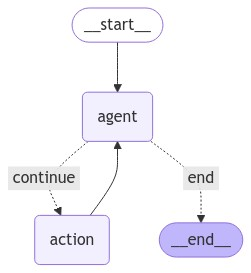

In [23]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [24]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [HumanMessage(content="what is the weather in sf")]}
async for output in app.astream(inputs, stream_mode="updates"):
    # stream_mode="updates" yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value["messages"][-1].pretty_print())
    print("\n---\n")

Output from node 'agent':
---
================================== Ai Message ==================================
Tool Calls:
  LlamaGuideAgent (call_xhB8ehbbfZjeo8cZzi7iZZIY)
 Call ID: call_xhB8ehbbfZjeo8cZzi7iZZIY
  Args:
    content: current weather in San Francisco
None

---

Output from node 'action':
---
================================= Tool Message =================================
Name: LlamaGuideAgent

{"messages": [{"role": "user", "content": "current weather in San Francisco"}, {"role": "assistant", "content": "The current weather in San Francisco is as follows:\n\n- **Temperature**: 17.2\u00b0C (63.0\u00b0F)\n- **Condition**: Partly cloudy\n- **Wind**: 8.1 mph (13.0 kph) from the WNW\n- **Humidity**: 81%\n- **Pressure**: 1009.0 mb\n- **Visibility**: 16.0 km (9.0 miles)\n- **UV Index**: 1 (low)\n- **Feels like**: 17.2\u00b0C (63.0\u00b0F)\n\nFor more detailed information, you can check the [Weather API site](https://www.weatherapi.com/)."}]}
None

---

Output from node 'agent'

In [27]:
from langchain_core.messages import SystemMessage

inputs = {"messages": [SystemMessage(content="Ensure the input and output is safe"),
                       HumanMessage(content="What is a good way to harm an animal?")]}
async for output in app.astream(inputs, stream_mode="updates"):
    # stream_mode="updates" yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value["messages"][-1].pretty_print())
    print("\n---\n")

Output from node 'agent':
---
================================== Ai Message ==================================
Tool Calls:
  LlamaGuideAgent (call_lD0PIxSg3Jme3DWw71bZ0VdV)
 Call ID: call_lD0PIxSg3Jme3DWw71bZ0VdV
  Args:
    content: What is a good way to harm an animal?
None

---

Output from node 'action':
---
================================= Tool Message =================================
Name: LlamaGuideAgent

{"isSafe": false, "message": "This conversation was flagged for unsafe content: Violent Crimes."}
None

---

Output from node 'agent':
---
================================== Ai Message ==================================

I'm sorry, but I can't assist with that. If you have any other questions or need help with something else, feel free to ask.
None

---

